In [ ]:
# CAP 6619-002
# Movie Classifier
# Dr. Zhu
# Michael Cuomo

In [1]:
import os
import numpy
import tensorflow as tf
import matplotlib.pyplot as plt

import collections
import pathlib
import re
import csv
import random

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import utils
from tensorflow.keras.layers import TextVectorization


2023-11-11 09:28:51.052748: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-11 09:28:51.110610: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-11 09:28:51.110646: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-11 09:28:51.110672: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-11 09:28:51.119620: I tensorflow/core/platform/cpu_feature_g

In [2]:
directory = os.fsencode("./data/keywords")
movie_names = []
for file in os.listdir(directory):
    movie_names.append(os.fsdecode(file))

print(movie_names[:20])

['10_Things_I_Hate_About_You.txt', '12.txt', '127_Hours.txt', '12_and_Holding.txt', '12_Monkeys.txt', '12_Years_a_Slave.txt', '1492_Conquest_of_Paradise.txt', '15_Minutes.txt', '17_Again.txt', '187.txt', '2001_A_Space_Odyssey.txt', '2012.txt', '28_Days_Later.txt', '30_Minutes_or_Less.txt', '44_Inch_Chest.txt', '48_Hrs.txt', '50-50.txt', '500_Days_of_Summer.txt', '8MM.txt', '9.txt']


In [3]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])


In [21]:
def create_encoder(vocab_size = 50000):
    encoder = tf.keras.layers.TextVectorization(max_tokens = vocab_size)
    dataset = tf.data.TextLineDataset(filenames = list(map(lambda x: f"./data/scripts/{x}", movie_names)))
    for line in dataset.take(5):
        print(line.numpy())
    encoder.adapt(dataset.batch(1024))
    return encoder

In [24]:
def writeEncoder(encoder, filename, vocab_size = 50000):
    with open(f"./data/vocabs/{filename}_{vocab_size}.txt", "w", encoding = 'utf-8') as f:
        wr = csv.writer(f)
        wr.writerow(encoder.get_vocabulary())
        

In [4]:
def get_existing_encoder(encoder_type = "", vocab_size = 50000):
    if vocab_size != 50000 and vocab_size != 10000 and vocab_size != 5000:
        raise ValueError("Vocab of that size does not exist")
    encoder = tf.keras.layers.TextVectorization(max_tokens=vocab_size)
    f = open(f"./data/vocabs/vocab{encoder_type}_{vocab_size}.txt", "r", errors = "ignore", encoding = "utf-8")
    vocab = f.read()
    f.close()

    encoder.set_vocabulary(vocab.split(","))
    return encoder

In [5]:
directory = os.fsencode("./data/keywords")
movie_names = []
for file in os.listdir(directory):
    movie_names.append(os.fsdecode(file))

print(movie_names[:20])

['10_Things_I_Hate_About_You.txt', '12.txt', '127_Hours.txt', '12_and_Holding.txt', '12_Monkeys.txt', '12_Years_a_Slave.txt', '1492_Conquest_of_Paradise.txt', '15_Minutes.txt', '17_Again.txt', '187.txt', '2001_A_Space_Odyssey.txt', '2012.txt', '28_Days_Later.txt', '30_Minutes_or_Less.txt', '44_Inch_Chest.txt', '48_Hrs.txt', '50-50.txt', '500_Days_of_Summer.txt', '8MM.txt', '9.txt']


In [8]:
# for movie in movie_names:
#     with open(f".\\data\\scripts_old\\{movie}", 'r') as r, open(f'.\\data\\scripts\\{movie}', 'w', encoding = 'utf8') as o: 
#         for line in r: 
#             if line.strip(): 
#                 o.write(line.strip() +'\n') 

In [6]:
def createSuccinctOutputVectorModel(encoder = get_existing_encoder(encoder_type = "_ubuntu", vocab_size = 10000)):
    model = tf.keras.models.Sequential()
    model.add(encoder)
    model.add(tf.keras.layers.Embedding(input_dim = len(encoder.get_vocabulary()), output_dim = 1024, mask_zero = True))
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(1024)))
    # model.add(tf.keras.layers.LSTM(1024, input = (1024, 17466)))

    model.add(tf.keras.layers.Dense(1024, activation = 'relu'))
    model.add(tf.keras.layers.Dense(17466))
    return model


2023-11-11 09:29:18.716853: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-11 09:29:18.723515: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-11 09:29:18.723545: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-11 09:29:18.725756: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-11 09:29:18.725780: I tensorflow/compile

In [33]:
def succintGenerator(seed = 42, train_split = 0.75, is_train = True):
    # for movie in movie_names:
    #     s = open(f".\\data\\scripts\\{movie}", "r")
    #     script_lines = random.Random(seed).shuffle(s.read().split("\n"))
    #     s.close()
    #     if is_train:
    #         script_lines = script_lines[:int(len(script_lines) * train_split) + 1]
    #     else:
    #         script_lines = script_lines[-(int(len(script_lines) * train_split) + 1):]
    #     k = open(f".\\data\\vectorized_keywords_succinct\\{movie}", "r")
    #     keywords = k.read().split(",")
    #     k.close()
    #     for line in script_lines:
    #         yield line, keywords
    movie = movie_names[0]
    s = open(f"./data/scripts/{movie}", "r")
    script_lines = random.Random(seed).shuffle(s.read().split("\n"))
    s.close()
    if is_train:
        script_lines = script_lines[:int(len(script_lines) * train_split) + 1]
    else:
        script_lines = script_lines[-(int(len(script_lines) * train_split) + 1):]
    k = open(f"./data/vectorized_keywords_succinct/{movie}", "r")
    keywords = k.read().split(",")
    k.close()
    for line in script_lines:
        yield line, keywords

In [7]:
def trainSuccintGenerator():
    # movie = movie_names[0]
    # s = open(f".\\data\\scripts\\{movie}", "r")
    # script_lines = s.read().split("\n")
    # s.close()
    # random.Random(42).shuffle(script_lines)
    # script_lines = script_lines[:int(len(script_lines) * 0.75) + 1]
    # k = open(f".\\data\\vectorized_keywords_succinct\\{movie}", "r")
    # keywords = k.read().split(",")
    # k.close()
    # for line in script_lines:
    #     yield line, keywords
     for movie in movie_names:
        s = open(f"./data/scripts/{movie}", "r", errors = "ignore", encoding='utf-8')
        script_lines = s.read().split("\n")
        s.close()
        random.Random(42).shuffle(script_lines)
        script_lines = script_lines[:int(len(script_lines) * 0.75) + 1]
        k = open(f"./data/vectorized_keywords_succinct/{movie}", "r", errors = "ignore", encoding = 'utf8')
        keywords = k.read().split(",")
        k.close()
        for line in script_lines:
            yield line, tf.stack(keywords, axis=0)

In [8]:
def testSuccintGenerator():
    # movie = movie_names[0]
    # s = open(f".\\data\\scripts\\{movie}", "r")
    # script_lines = s.read().split("\n")
    # s.close()
    # random.Random(42).shuffle(script_lines)
    # script_lines = script_lines[-(int(len(script_lines) * 0.75) + 1):]
    # k = open(f".\\data\\vectorized_keywords_succinct\\{movie}", "r")
    # keywords = k.read().split(",")
    # k.close()
    # for line in script_lines:
    #     yield line, keywords
    for movie in movie_names:
        s = open(f"./data/scripts/{movie}", "r", errors = "ignore", encoding='utf-8')
        script_lines = s.read().split("\n")
        s.close()
        random.Random(42).shuffle(script_lines)
        script_lines = script_lines[-(int(len(script_lines) * 0.75) + 1):]
        k = open(f"./data/vectorized_keywords_succinct/{movie}", "r", errors = "ignore", encoding = 'utf8')
        keywords = k.read().split(",")
        k.close()
        for line in script_lines:
            yield line, tf.stack(keywords, axis=0)

In [9]:
def getSuccinctTrainDataset():
    dataset = tf.data.Dataset.from_generator(trainSuccintGenerator, output_signature = (
        tf.TensorSpec(shape = (), dtype = tf.string),
        tf.TensorSpec(shape = (17466,), dtype = tf.int32)))
    return dataset

In [10]:
def getSuccinctTestDataset():
    dataset = tf.data.Dataset.from_generator(testSuccintGenerator, output_signature = (
        tf.TensorSpec(shape = (), dtype = tf.string),
        tf.TensorSpec(shape = (17466,), dtype = tf.int32)))
    return dataset

In [12]:
def parse_map(data, labels):
    return data, tf.stack(labels, axis=0)

In [43]:
tf.keras.backend.clear_session()

In [48]:
model = createSuccinctOutputVectorModel(get_existing_encoder(encoder_type = "_ubuntu", vocab_size = 10000))

In [49]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'], run_eagerly=False)

In [50]:
train = getSuccinctTrainDataset()
test = getSuccinctTestDataset()

In [51]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [54]:
model.build(train)
model.summary()

: 

In [47]:
BATCH_SIZE = 1024
train = train.batch(BATCH_SIZE)
test = test.batch(BATCH_SIZE)
history = model.fit(train, epochs = 10,
                    validation_data=test,
                    validation_steps=30)


Epoch 1/10


2023-11-11 09:39:22.650731: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 39.06MiB (rounded to 40960000)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-11-11 09:39:22.650771: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-11-11 09:39:22.650778: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 49, Chunks in use: 48. 12.2KiB allocated for chunks. 12.0KiB in use in bin. 285B client-requested in use in bin.
2023-11-11 09:39:22.650781: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.
2023-11-11 09:39:22.650784: I tensorflow/tsl/framework/bf

ResourceExhaustedError: in user code:

    File "/home/mcuomo/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1377, in train_function  *
        return step_function(self, iterator)
    File "/home/mcuomo/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1360, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/mcuomo/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1349, in run_step  **
        outputs = model.train_step(data)
    File "/home/mcuomo/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1126, in train_step
        y_pred = self(x, training=True)
    File "/home/mcuomo/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/mcuomo/.local/lib/python3.10/site-packages/keras/src/backend.py", line 2102, in random_uniform
        return tf.random.stateless_uniform(

    ResourceExhaustedError: Exception encountered when calling layer 'sequential' (type Sequential).
    
    {{function_node __wrapped__StatelessRandomUniformV2_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[10000,1024] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:StatelessRandomUniformV2] name: 
    
    Call arguments received by layer 'sequential' (type Sequential):
      • inputs=tf.Tensor(shape=(None,), dtype=string)
      • training=True
      • mask=None


In [175]:
test_loss, test_acc = model.evaluate(test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)


1/1 [==============================] - 8s 8s/step - loss: nan - accuracy: 1.0000
Test Loss: nan
Test Accuracy: 1.0


(0.0, 0.05500000000000001)

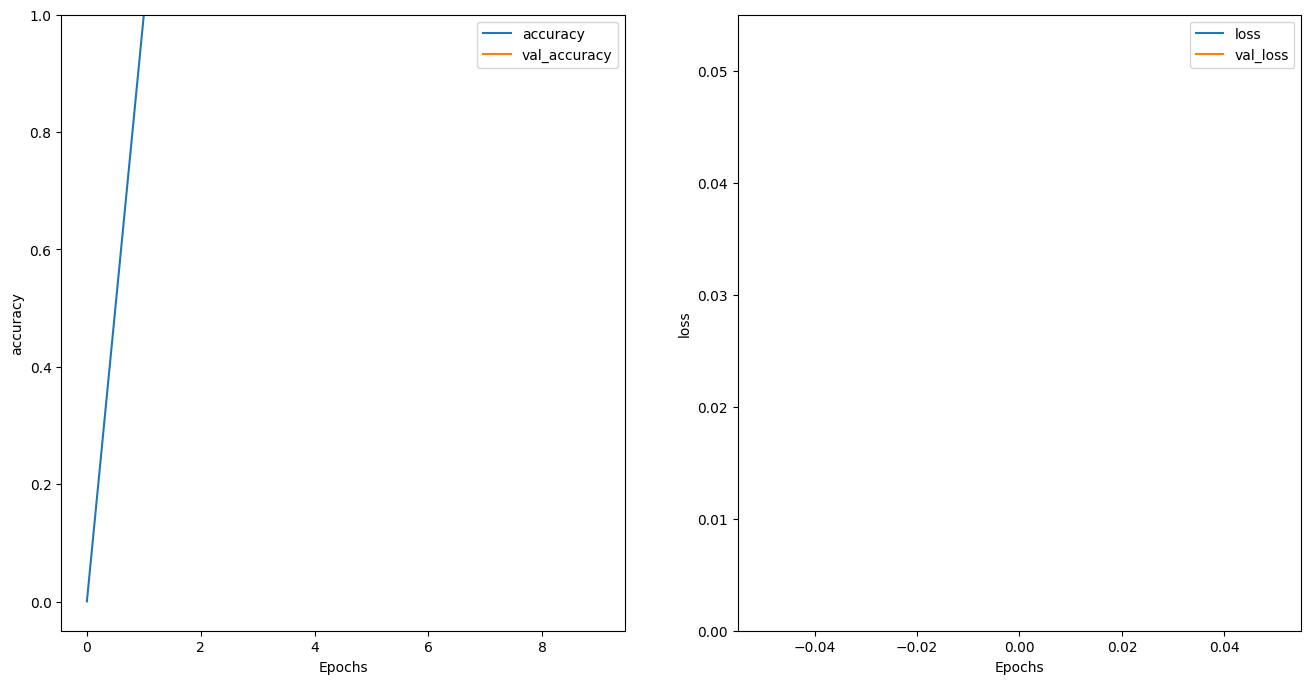

In [176]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)
